# Import Libraries

In [1]:
from bs4 import BeautifulSoup
import requests
import json
from urllib.parse import urlparse

# 1. SiteMap tree - JSON output

In [2]:
sitemap_url = "https://www.industrial.marketing/sitemap.xml"
#sitemap_url = "https://www.northlightai.com/sitemap.xml"

while True:
    raw_input_url = input("Enter your website domain (e.g., www.example.com): ").strip()

    # Prepend https:// if missing
    if not raw_input_url.startswith("http"):
        sitemap_url = "https://" + raw_input_url
    else:
        sitemap_url = raw_input_url

    parsed_url = urlparse(sitemap_url)

    if parsed_url.scheme.startswith("http") and parsed_url.netloc:
        break  # Valid format
    else:
        print("⚠️ Invalid input. Please enter a domain like www.example.com")

# Append /sitemap.xml if needed
if not sitemap_url.endswith("/sitemap.xml"):
    sitemap_url = sitemap_url.rstrip("/") + "/sitemap.xml"

print(f"✅ Final sitemap URL: {sitemap_url}")



# Validate and show parsed domain
print(f"Parsed domain: {urlparse(sitemap_url).netloc}")

def fetch_sitemap(URL, headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/113.0.0.0 Safari/537.36"}):
    try:
        response = requests.get(URL, headers=headers, timeout=5)
        response.raise_for_status()  # Raise an error for bad responses
        Links = BeautifulSoup(response.content, 'lxml-xml').find_all('loc')
        return [l.text for l in Links]
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {URL}: {e}")
        return None
# Test
Link_List = fetch_sitemap(sitemap_url)
print(f"{len(Link_List)} links were found in the first layer of the sitemap.")
print("Listed links: ", Link_List)
print("===================================")
#print("First Link is ",Link_List[0])
#print("===================================")

# Recursive function to parse the sitemap
# This function will be called recursively to build the tree structure
def parse_sitemap(url):
    locs = fetch_sitemap(url)
    if not locs:
        return {}

    urls = []
    tree = {}

    for loc in locs:
        if loc.endswith('.xml'):
            # Recurse into sub-sitemaps
            subtree = parse_sitemap(loc)
            tree[loc] = subtree if subtree else []
        else:
            # Collect actual HTML/page URLs (final links)
            urls.append(loc)

    # If this level had HTMLs, return them as list
    # If it had XMLs, return dict (tree). If both, include both
    if tree and urls:
        tree["_final_urls"] = urls  # special key to store final URLs at this level
        return tree
    elif urls:
        return urls
    else:
        return tree

# List of all HTML pages
def collect_all_final_urls(sitemap_tree):
    final_urls = []

    def extract_urls(tree):
        for key, val in tree.items():
            if isinstance(val, list):
                final_urls.extend(val)
            elif isinstance(val, dict):
                extract_urls(val)

    extract_urls(sitemap_tree)
    return final_urls

# Test
sitemap_tree = {sitemap_url: parse_sitemap(sitemap_url)}
print("Sitemap tree:")
print(sitemap_tree)
print("===================================")
print("Final URLs:")
final_urls = collect_all_final_urls(sitemap_tree)
print(f"Total final URLs: {len(final_urls)}")
print(final_urls)

# Save tree
#with open("sitemap_tree_clean.json", "w") as f:
#    json.dump(sitemap_tree, f, indent=2)


✅ Final sitemap URL: https://www.northlightai.com/sitemap.xml
Parsed domain: www.northlightai.com
3 links were found in the first layer of the sitemap.
Listed links:  ['https://northlightai.com/sitemap.website.xml', 'https://northlightai.com/sitemap.blog.xml', 'https://northlightai.com/sitemap.ols.xml']
Sitemap tree:
{'https://www.northlightai.com/sitemap.xml': {'https://northlightai.com/sitemap.website.xml': ['https://northlightai.com/publications', 'https://northlightai.com/nhadc', 'https://northlightai.com/faq', 'https://northlightai.com/our-customers-1', 'https://northlightai.com/', 'https://northlightai.com/ai-strategic-consulting', 'https://northlightai.com/ai-innovation-lab', 'https://northlightai.com/our-team', 'https://northlightai.com/higher-education', 'https://northlightai.com/product-development', 'https://northlightai.com/north-light-values', 'https://northlightai.com/ai-training-%26-development-1', 'https://northlightai.com/technical-partners', 'https://northlightai.com/

# 2. Visualization based on the JSOn output

## 2.1 Using Networkx

In [3]:
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque

In [4]:
# 1. Convert tree to edges
def tree_to_edges(tree, parent=None):
    edges = []

    if isinstance(tree, list):
        for item in tree:
            edges.append((parent, item))
    elif isinstance(tree, dict):
        for key, value in tree.items():
            if parent:
                edges.append((parent, key))
            edges += tree_to_edges(value, parent=key)

    return edges

edges = tree_to_edges(sitemap_tree[sitemap_url], parent=sitemap_url)

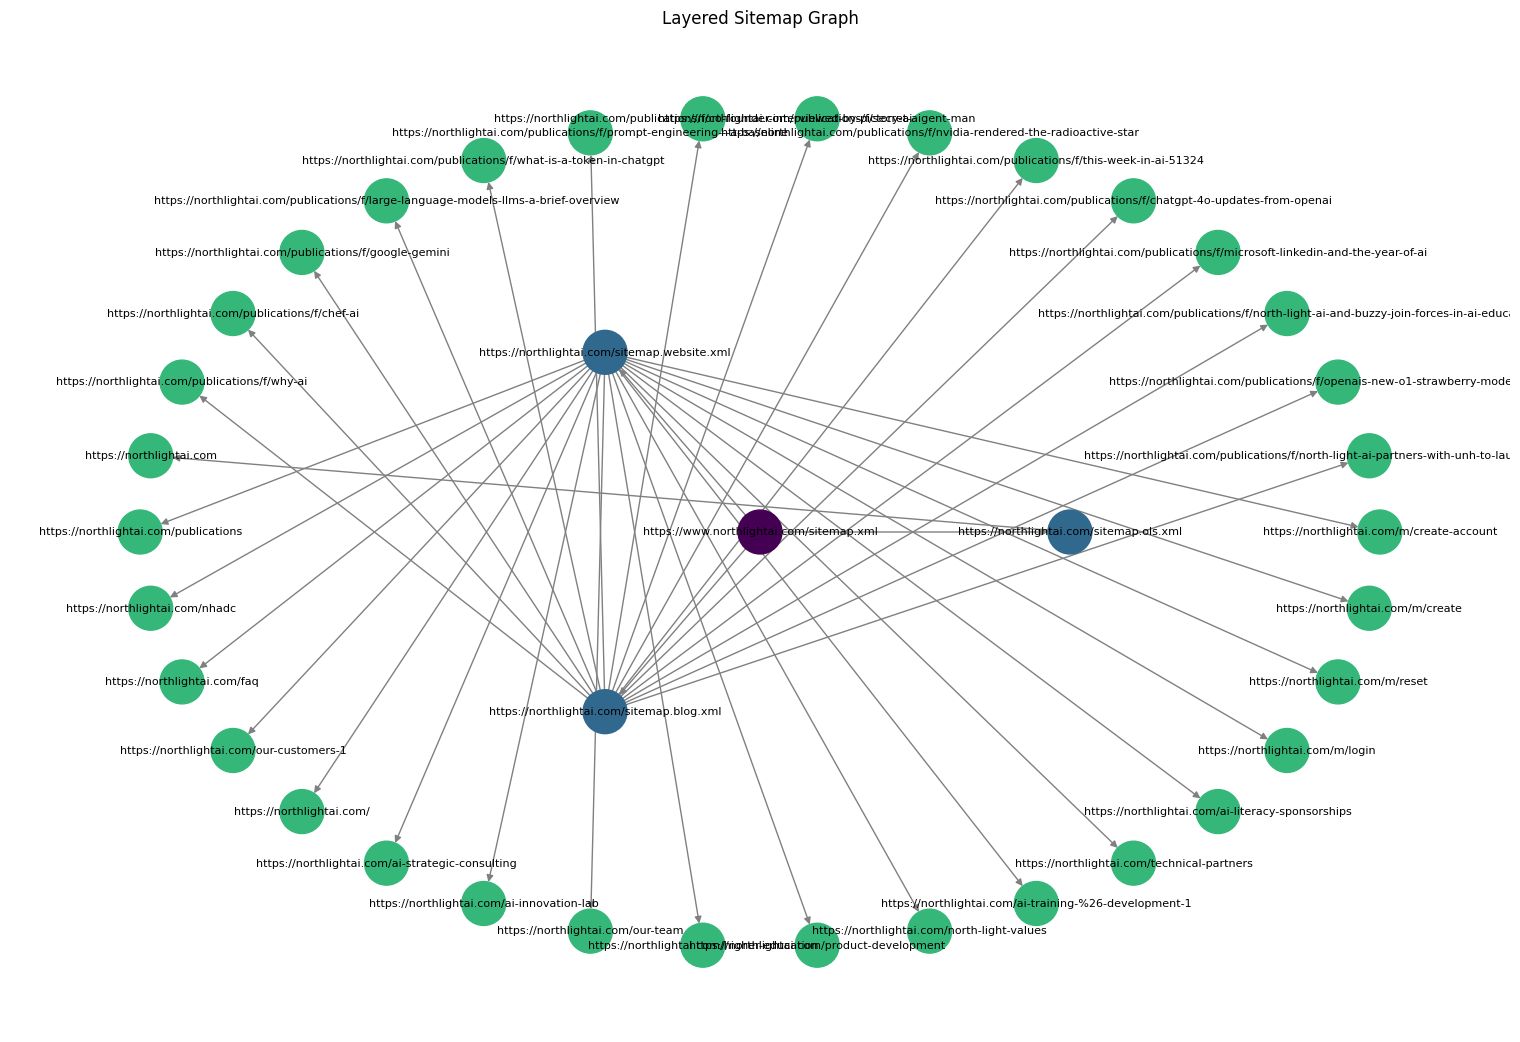

In [5]:


def assign_layers(edges, root):
    graph = defaultdict(list)
    for parent, child in edges:
        graph[parent].append(child)

    layers = defaultdict(list)
    visited = set()
    queue = deque([(root, 0)])

    while queue:
        node, depth = queue.popleft()
        if node in visited:
            continue
        visited.add(node)
        layers[depth].append(node)
        for child in graph.get(node, []):
            queue.append((child, depth + 1))

    return layers


# 2. Assign layers
layers = assign_layers(edges, root=sitemap_url)
layer_list = [layers[i] for i in sorted(layers)]

# 3. Build graph
G = nx.DiGraph()
G.add_edges_from(edges)

# 4. Get layout using shell_layout
pos = nx.shell_layout(G, nlist=layer_list)

#pos = nx.kamada_kawai_layout(G)

# 5. Color nodes by layer
color_map = []
for node in G.nodes():
    for i, layer in enumerate(layer_list):
        if node in layer:
            color_map.append(plt.cm.viridis(i / len(layer_list)))
            break

# 6. Draw graph
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_color=color_map, node_size=1000,
        font_size=8, edge_color='gray', arrows=True)
plt.title("Layered Sitemap Graph")
plt.show()




## 2.2 Using pyviz

In [6]:
from pyvis.network import Network
import networkx as nx

In [7]:
# Build a networkx graph
G = nx.DiGraph()
G.add_edges_from(edges)

# Create a pyvis network
net = Network(height="750px", width="100%", directed=True, notebook=False)

# Add nodes and edges to pyvis from networkx
for node in G.nodes():
    if node == sitemap_url:
        net.add_node(node, label=str(urlparse(sitemap_url).netloc), title=node, shape='dot', size=30, color={
        "background": "white",
        "border": "blue"
    },
    borderWidth=4,  # Thick border
    font={
        "color": "black",
        "size": 35,
        "bold": True,
        "vadjust": 0,
        "highlight": {
            "background": "white",
            "border": "darkblue"
        }
    })
        
        #print(str(urlparse(sitemap_url).netloc))
        #print(node.split("/")[-2])
    elif node.endswith('.xml'):
        net.add_node(node, label="Sitemap", title=node, shape='dot', size=25, font={
        "color": "black",
        "size": 25,
        "bold": True,
        "vadjust": 0,
        "highlight": {
            "background": "white",
            "border": "darkblue"
        }
    })
        

        
    else:
        net.add_node(node, label=" ", title=node, shape='dot', size=15,
    color={
        "background": "#ccffcc",  # light green background
        "border": "#009933",     # dark green border
        "highlight": {
            "background": "#b3ffb3",  # lighter green when hovered
            "border": "#006600"
        }
    })
    
for source, target in G.edges():
    net.add_edge(source, target)

# Customize physics (optional)
net.force_atlas_2based()

# Customize physics and drag behavior
net.set_options("""
{
  "physics": {
    "stabilization": false
  },
  "interaction": {
    "dragNodes": true
  }
}
""")



# Title
net.add_node("graph_title", 
             label=f"Sitemap Tree: {urlparse(sitemap_url).netloc}",
             shape="box",
             size=0,
             font={"size": 60, "color": "black", "bold": True},
             physics=False,
             fixed={"x": True, "y": True},
             x=0, y=-750,
             color={
                 "background": "white",
                 "border": "white",
                 "highlight": {
                     "background": "white",
                     "border": "white"
                 }
             },
             borderWidth=0  # Optional: fully remove visible border line
)

# Save and show the network
net.write_html("sitemap_network.html")
#net.show("sitemap_network.html")

# Inject custom JavaScript into the HTML file to show the label on click.

with open("sitemap_network.html", "r", encoding="utf-8") as f:
    html = f.read()

# Inject JavaScript to show label on click
inject_js = f"""
<script type="text/javascript">
  window.addEventListener("load", function () {{
    const rootNodeId = "{sitemap_url}";
    const titleNodeId = "graph_title";  // Add this line
    const originalLabels = {{}};

    network.on("click", function (params) {{
      if (params.nodes.length > 0) {{
        let clickedNodeId = params.nodes[0];

        nodes.get().forEach(function (node) {{
          if (!(node.id in originalLabels)) {{
            originalLabels[node.id] = node.label;
          }}

          if (node.id === rootNodeId || node.id === titleNodeId) {{
            // Skip root node and title node
            return;
          }}

          if (node.id === clickedNodeId) {{
            nodes.update({{id: node.id, label: node.title}});
          }} else {{
            nodes.update({{id: node.id, label: ""}});
          }}
        }});
      }} else {{
        // Clicked background: reset all except root and title
        nodes.get().forEach(function (node) {{
          if (node.id !== rootNodeId && node.id !== titleNodeId && originalLabels[node.id] === "") {{
            nodes.update({{id: node.id, label: ""}});
          }}
        }});
      }}
    }});
  }});
</script>
"""


# Inject before the closing </body> tag
html = html.replace("</body>", inject_js + "\n</body>")

# Save the modified HTML
with open("sitemap_network.html", "w", encoding="utf-8") as f:
    f.write(html)
